## Creating synthetic data


Loading the VERDICT MODEL 
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}

In [4]:
# load the necessary modules
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel, MultiCompartmentSphericalHarmonicsModel

sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=1.2e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 2e-9) #2
verdict_mod.set_parameter_optimization_bounds('C1Stick_1_lambda_par', [3.05e-9, 10e-9])

Loading acquisition scheme

In [5]:
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from os.path import join

acquisition_path_GS55 = "/Users/theavage/Documents/Master/Data/GS55 - long acquisition"

scheme= acquisition_scheme_from_schemefile(join(acquisition_path_GS55,"GS55_long_protocol2.scheme"))

In [6]:
import numpy as np

ranges = np.arange(0.1,1.1,0.1)
ic = ranges; ec = ranges; vasc = ranges
radi = np.arange(0.02e-6,30e-6,1e-6)
all_fcomb= []

for i in ic:
    for j in ec:
        for k in vasc:
            if i+j+k == 1:
                for r in radi:
                    all_fcomb.append([r,2,1,3.05000000e-09,i,j,k])

for i in range(4):
    all_fcomb.append(np.zeros(7))
f_array = np.array(all_fcomb)
f_array.shape
parameter_vector = f_array.reshape(32,32,7)
parameter_vector.shape


(32, 32, 7)

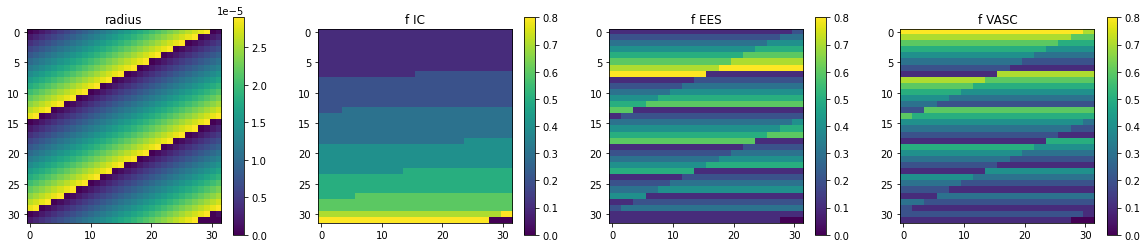

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numpy import isin
%matplotlib inline

fig, ax = plt.subplots(1,4,figsize=(20,20))
names = ['radius','f IC','f EES', 'f VASC']
for i in range(4):
    if i > 0:
        image = ax[i].imshow(parameter_vector[:,:,i+3])
        fig.colorbar(image,ax=ax[i],shrink=0.2)
        ax[i].set_title(names[i])
    else:
        image = ax[i].imshow(parameter_vector[:,:,i])
        fig.colorbar(image,ax=ax[i],shrink=0.2)
        ax[i].set_title(names[i])


In [31]:
simulated_signal = verdict_mod.simulate_signal(scheme,parameter_vector)
simulated_signal.shape


/Users/theavage/opt/anaconda3/lib/python3.9/site-packages/dmipy/signal_models/sphere_models.py:307: RuntimeWarning: divide by zero encountered in true_divide
  alpha = self.SPHERE_TRASCENDENTAL_ROOTS / radius
/Users/theavage/opt/anaconda3/lib/python3.9/site-packages/dmipy/signal_models/sphere_models.py:313: RuntimeWarning: invalid value encountered in multiply
  alpha ** (-4) / (alpha2 * radius ** 2 - 2) *


(32, 32, 160)

0.9263503793212613

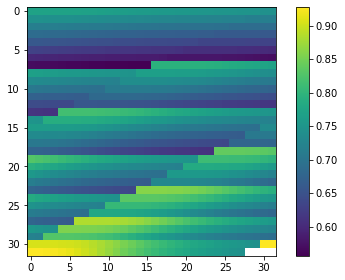

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)

image = ax.imshow(simulated_signal[:,:,89])
fig.colorbar(image,ax=ax)
simulated_signal[1,1,1]

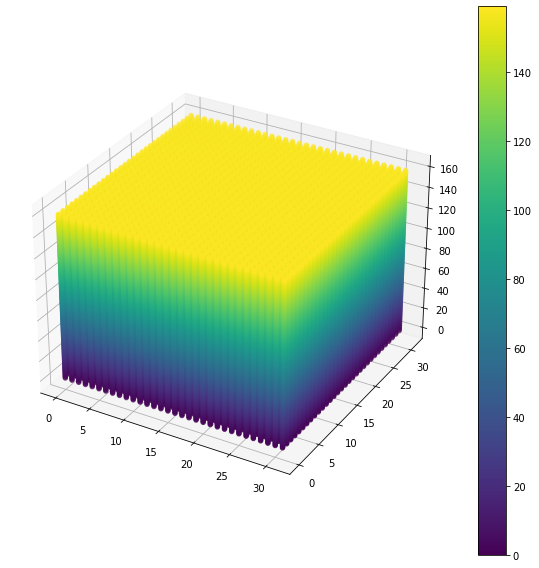

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [8,8]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
image = fig.add_subplot(111,projection='3d')
#cb = fig.colorbar(image,ax=image)

#x,y,z = simulated_signal.nonzero()
x = np.arange(simulated_signal.shape[0])[:, None, None]
y = np.arange(simulated_signal.shape[1])[None, :, None]
z = np.arange(simulated_signal.shape[2])[None, None, :]
x, y, z = np.broadcast_arrays(x, y, z)
p = image.scatter(x,y,z,c=z)

fig.colorbar(p,ax=image)
plt.show()


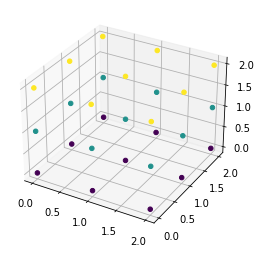

In [33]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
data = np.random.random(size=(3, 3, 3))
z, x, y = data.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)
plt.show()


In [51]:
verdict_fit = verdict_mod.fit(scheme, simulated_signal[1,1,:],solver='mix', use_parallel_processing=False)

Setup MIX optimizer in 1.3113021850585938e-05 seconds
Fitting of 1 voxels complete in 31.80046796798706 seconds.
Average of 31.80046796798706 seconds per voxel.


In [55]:
new_fit = verdict_mod.fit(scheme, simulated_signal[0,0,:],solver='mix', use_parallel_processing=False)

Setup MIX optimizer in 1.0967254638671875e-05 seconds
Fitting of 1 voxels complete in 31.81956195831299 seconds.
Average of 31.81956195831299 seconds per voxel.


In [52]:
verdict_fit.fitted_parameters

{'S4SphereGaussianPhaseApproximation_1_diameter': array([2.84611217e-06]),
 'C1Stick_1_mu': array([[ 2.00000895, -0.99999038]]),
 'C1Stick_1_lambda_par': array([3.05e-09]),
 'partial_volume_0': array([0.09996913]),
 'partial_volume_1': array([0.19999759]),
 'partial_volume_2': array([0.70003328])}

In [56]:
new_fit.fitted_parameters

{'S4SphereGaussianPhaseApproximation_1_diameter': array([2.0009385e-08]),
 'C1Stick_1_mu': array([[ 2.00000006, -0.99999995]]),
 'C1Stick_1_lambda_par': array([3.05000141e-09]),
 'partial_volume_0': array([0.10000009]),
 'partial_volume_1': array([0.09999965]),
 'partial_volume_2': array([0.80000026])}

In [62]:
parameter_vector[0,0]

array([2.00e-08, 2.00e+00, 1.00e+00, 3.05e-09, 1.00e-01, 1.00e-01,
       8.00e-01])